In [1]:
import pandas as pd
import numpy as np
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site
from pyNBA.Data.constants import (ROTOWIRE_NAME_TO_NBA_NAME, LINESTARAPP_TEAM_TO_NBA_TEAM,
                                  LINESTARAPP_NAME_TO_NBA_NAME, OWNERSHIP_NAME_TO_NBA_NAME,
                                  BAD_CONTEST_SUBSTRINGS)

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
query_data = QueryData(update=False)
clean_data = CleanData()

linestarapp_data = query_data.query_linestarapp_data()
linestarapp_data = linestarapp_data.loc[linestarapp_data['SITE'] == 'DRAFTKINGS']
linestarapp_data['PLAYER_NAME'] = linestarapp_data['PLAYER_NAME'].apply(
    lambda x: x if x not in LINESTARAPP_NAME_TO_NBA_NAME else LINESTARAPP_NAME_TO_NBA_NAME[x]
)
linestarapp_data['TEAM'] = linestarapp_data['TEAM'].apply(
    lambda x: x if x not in LINESTARAPP_TEAM_TO_NBA_TEAM else LINESTARAPP_TEAM_TO_NBA_TEAM[x]
)

rotowire_data = query_data.query_rotowire_data()
rotowire_data = rotowire_data.drop(columns=['TEAM', 'POS', 'G'])
rotowire_data['PLAYER_NAME'] = rotowire_data['PLAYER_NAME'].apply(
    lambda x: x if x not in ROTOWIRE_NAME_TO_NBA_NAME else ROTOWIRE_NAME_TO_NBA_NAME[x]
)

salary_data = query_data.query_salary_data()
salary_data = salary_data.loc[salary_data['SITE'] == 'DRAFTKINGS']
salary_data['POSITION'] = salary_data['POSITION'].apply(lambda x: x.replace('_', '/'))
salary_data['NAME'] = salary_data['PLAYER'].apply(clean_data.convert_rotoguru_name_to_nba_name)

contest_data = query_data.query_contest_data()
contest_data = contest_data.loc[contest_data['SITE'] == 'DRAFTKINGS']
contest_data = contest_data.loc[
    (contest_data['SLATETYPE'] == 'Classic') & (contest_data['CASHLINE'] > 200) & (contest_data['TOTALENTRIES'] > 100) &
    (~contest_data['CONTESTNAME'].str.lower().str.contains('|'.join(BAD_CONTEST_SUBSTRINGS)))
].dropna(subset=['CASHLINE'])
contest_data['MAXROI'] = contest_data['TOPPRIZE']/contest_data['ENTRYFEE']
contest_data = contest_data.loc[contest_data['MAXROI'] > 2]

ownership_data = query_data.query_ownership_data()
ownership_data['PLAYERNAME'] = ownership_data['PLAYERNAME'].apply(
    lambda x: x if x not in OWNERSHIP_NAME_TO_NBA_NAME else OWNERSHIP_NAME_TO_NBA_NAME[x]
)
ownership_data = ownership_data.rename(columns={'PLAYERNAME': 'PLAYER_NAME'})
ownership_data = ownership_data.groupby(['SLATEID', 'PLAYER_NAME'])['OWNERSHIP'].mean().reset_index()

boxscore_data = query_data.query_boxscore_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [3]:
def _get_projection(roto_projection, linestar_projection):
    if np.isnan(roto_projection) and np.isnan(linestar_projection):
        return 0
    elif np.isnan(roto_projection):
        return linestar_projection
    elif np.isnan(linestar_projection):
        return roto_projection
    elif roto_projection == 0 and linestar_projection != 0:
        return linestar_projection
    elif roto_projection != 0 and linestar_projection == 0:
        return 0
    else:
        return roto_projection

linestarapp_data = linestarapp_data.loc[linestarapp_data['SITE'] == 'DRAFTKINGS']
linestarapp_data = linestarapp_data.rename(columns={'PROJECTION': 'LINESTARAPP_PROJECTION'})

rotowire_data['ROTOWIRE_PROJECTION'] = rotowire_data.apply(
    lambda row: FPCalculator.calculate_draftkings_fp(
        row['PTS'], row['REB'], row['AST'], row['TOV'], row['BLK'], row['STL'], row['THREEPM'], (row['DBLDBL'], row['TRPDBL'])
    ),
    axis=1
)
projections = linestarapp_data.merge(rotowire_data, on=['DATE', 'PLAYER_NAME'], how='left')
projections['PROJECTION'] = projections.apply(
    lambda row: _get_projection(row['ROTOWIRE_PROJECTION'], row['LINESTARAPP_PROJECTION']),
    axis=1
)

player_comments = boxscore_data[['DATE', 'NAME', 'COMMENT']]
player_comments = player_comments.rename(columns={'NAME': 'PLAYER_NAME'})
projections = projections.merge(player_comments, on=['DATE', 'PLAYER_NAME'], how='left')

projections = projections.loc[projections['DATE'].isin(set(boxscore_data['DATE'].unique()))]
projections = projections[[
    'DATE', 'SITE', 'PLAYER_ID', 'PLAYER_NAME', 'POS', 'TEAM', 'START', 'SPREAD', 'TOTAL',
    'OPPRANK_DvP_L20', 'OPPRANK_D_L20', 'PROJECTION', 'FINAL', 'COMMENT'
]]

projections

,DATE,SITE,PLAYER_ID,PLAYER_NAME,POS,TEAM,START,SPREAD,TOTAL,OPPRANK_DvP_L20,OPPRANK_D_L20,PROJECTION,FINAL,COMMENT
0,2015-10-27,DRAFTKINGS,138,Anderson Varejao,C,CLE,NaN,NaN,NaN,NaN,NaN,13.291550,6.50,
1,2015-10-27,DRAFTKINGS,196,Earl Barron,C,ATL,NaN,NaN,NaN,NaN,NaN,6.640000,0.00,NaN
2,2015-10-27,DRAFTKINGS,396,Kendrick Perkins,C,NOP,NaN,NaN,NaN,NaN,NaN,18.150000,16.50,
3,2015-10-27,DRAFTKINGS,381,Alexis Ajinca,C,NOP,NaN,NaN,NaN,NaN,NaN,15.190000,10.50,
4,2015-10-27,DRAFTKINGS,211,Tiago Splitter,C,ATL,NaN,NaN,NaN,NaN,NaN,19.260000,11.00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238868,2021-05-16,DRAFTKINGS,889,Justin Jackson,PF,MIL,0.0,-7.5,224.5,8.0,12.0,0.000000,18.50,
238869,2021-05-16,DRAFTKINGS,1299,Jordan Nwora,PF,MIL,0.0,-7.5,224.5,8.0,12.0,0.000000,59.50,
238870,2021-05-16,DRAFTKINGS,1377,Josh Hall,PF,OKC,1.0,8.0,220.5,19.0,4.0,10.515493,41.00,
238871,2021-05-16,DRAFTKINGS,1207,Nicolo Melli,PF,DAL,0.0,-7.5,230.0,25.0,25.0,8.550000,22.25,


In [4]:
salaries = linestarapp_data.merge(
    salary_data,
    left_on=['SITE', 'DATE', 'PLAYER_NAME', 'POS'],
    right_on=['SITE', 'DATE', 'NAME', 'POSITION'],
    how='left',
    suffixes = ('_linestarrapp', '_rotoguru')
)

salaries = salaries.loc[salaries['DATE'].isin(set(boxscore_data['DATE'].unique()))]

salaries['SALARY'] = salaries[['SALARY_linestarrapp', 'SALARY_rotoguru']].min(axis=1)
salaries.loc[salaries['SALARY'] < 3000, 'SALARY'] = 3000
salaries = salaries[['DATE', 'SITE', 'PLAYER_ID', 'PLAYER_NAME', 'POS', 'TEAM', 'SALARY']]

salaries

,DATE,SITE,PLAYER_ID,PLAYER_NAME,POS,TEAM,SALARY
0,2015-10-27,DRAFTKINGS,138,Anderson Varejao,C,CLE,3400.0
1,2015-10-27,DRAFTKINGS,196,Earl Barron,C,ATL,3000.0
2,2015-10-27,DRAFTKINGS,396,Kendrick Perkins,C,NOP,3000.0
3,2015-10-27,DRAFTKINGS,381,Alexis Ajinca,C,NOP,3500.0
4,2015-10-27,DRAFTKINGS,211,Tiago Splitter,C,ATL,4500.0
...,...,...,...,...,...,...,...
238868,2021-05-16,DRAFTKINGS,889,Justin Jackson,PF,MIL,3000.0
238869,2021-05-16,DRAFTKINGS,1299,Jordan Nwora,PF,MIL,3000.0
238870,2021-05-16,DRAFTKINGS,1377,Josh Hall,PF,OKC,3000.0
238871,2021-05-16,DRAFTKINGS,1207,Nicolo Melli,PF,DAL,3000.0


In [5]:
slate_dates = contest_data[['DATE', 'SITE', 'SLATEID', 'GAMECOUNT']].drop_duplicates()
ownerships = ownership_data.merge(slate_dates, on=['SLATEID'], how='inner')

slate_players_per_game = (
    ownerships.groupby('SLATEID')['PLAYER_NAME'].count() / ownerships.groupby('SLATEID')['GAMECOUNT'].first()
).reset_index()
bad_slates = slate_players_per_game.loc[
    (slate_players_per_game[0] < 20) |
    (slate_players_per_game[0] > 40)
]['SLATEID'].unique()
ownerships = ownerships.loc[~ownerships['SLATEID'].isin(bad_slates)]

ownerships

,SLATEID,PLAYER_NAME,OWNERSHIP,DATE,SITE,GAMECOUNT
0,5ae4aa4e95356d3dfbd75b88,AJ Hammons,0.000183,2018-01-27,DRAFTKINGS,6
1,5ae4aa4e95356d3dfbd75b88,Aaron Brooks,0.000000,2018-01-27,DRAFTKINGS,6
2,5ae4aa4e95356d3dfbd75b88,Aaron Gordon,0.123631,2018-01-27,DRAFTKINGS,6
3,5ae4aa4e95356d3dfbd75b88,Abdel Nader,0.000067,2018-01-27,DRAFTKINGS,6
4,5ae4aa4e95356d3dfbd75b88,Adreian Payne,0.000100,2018-01-27,DRAFTKINGS,6
...,...,...,...,...,...,...
151609,5e6a282ee286d854732c3174,Trae Young,0.722200,2020-03-11,DRAFTKINGS,2
151610,5e6a282ee286d854732c3174,Treveon Graham,0.000300,2020-03-11,DRAFTKINGS,2
151611,5e6a282ee286d854732c3174,Tyler Herro,0.070000,2020-03-11,DRAFTKINGS,2
151612,5e6a282ee286d854732c3174,Vince Carter,0.001000,2020-03-11,DRAFTKINGS,2


In [6]:
df = ownerships.merge(
    salaries,
    on=['DATE', 'SITE', 'PLAYER_NAME'],
    how='left'
)

df = df.merge(
    projections,
    on=['DATE', 'SITE', 'PLAYER_ID', 'PLAYER_NAME', 'POS', 'TEAM'],
    how='left'
)

season_dates = boxscore_data[['SEASON', 'DATE']].drop_duplicates()
df = df.merge(
    season_dates,
    on=['DATE'],
    how='left'
)

df = df.dropna(subset=['SALARY'])
df = df.loc[
    (df['PROJECTION'] != 0) |
    (df['COMMENT'] == '') |
    (df['COMMENT'].str.contains('coach', case=False))
]

pd.set_option('display.max_columns', None)
df[[
    'SEASON', 'DATE', 'SLATEID', 'GAMECOUNT', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM', 'POS', 'SALARY',
    'START', 'SPREAD', 'TOTAL', 'OPPRANK_DvP_L20', 'OPPRANK_D_L20', 'PROJECTION', 'FINAL', 'OWNERSHIP',
    'COMMENT'
]].sort_values(by=['DATE', 'SLATEID', 'SALARY'], ascending=[True, False, False])

,SEASON,DATE,SLATEID,GAMECOUNT,PLAYER_ID,PLAYER_NAME,TEAM,POS,SALARY,START,SPREAD,TOTAL,OPPRANK_DvP_L20,OPPRANK_D_L20,PROJECTION,FINAL,OWNERSHIP,COMMENT
43907,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,512.0,Karl-Anthony Towns,MIN,C,9400.0,1.0,1.0,203.5,15.0,8.0,44.133727,42.25,0.586100,
43919,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,489.0,Nikola Jokic,DEN,PF/C,9100.0,1.0,2.5,205.0,9.0,1.0,38.072550,31.00,0.253667,
43927,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,558.0,Rudy Gobert,UTA,C,8800.0,1.0,-2.5,205.0,26.0,22.0,42.152678,32.50,0.426533,
43901,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,102.0,Jimmy Butler,MIN,SG,8100.0,1.0,1.0,203.5,17.0,8.0,36.366373,23.00,0.530100,
43911,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,438.0,LaMarcus Aldridge,SAS,PF/C,7300.0,1.0,-1.0,203.5,15.0,23.0,30.290000,48.00,0.488433,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151216,2019-20,2020-03-11,5e696e13f4053b1dcb589c40,6,559.0,Treveon Graham,ATL,SF,3000.0,0.0,-5.0,232.5,20.0,9.0,9.920000,11.75,0.000188,
151217,2019-20,2020-03-11,5e696e13f4053b1dcb589c40,6,274.0,Troy Daniels,DEN,SG,3000.0,0.0,-2.5,220.5,19.0,20.0,0.000000,0.00,0.000120,DNP - Coach's Decision
151219,2019-20,2020-03-11,5e696e13f4053b1dcb589c40,6,222.0,Udonis Haslem,MIA,C,3000.0,0.0,-11.0,206.5,10.0,19.0,0.000000,0.00,0.000100,DNP - Coach's Decision
151220,2019-20,2020-03-11,5e696e13f4053b1dcb589c40,6,462.0,Vince Carter,ATL,SF/PF,3000.0,0.0,-5.0,232.5,20.0,9.0,8.380000,6.75,0.000350,


In [7]:
from pyNBA.Models.features import FeatureCreation

feature_creation = FeatureCreation()

df['VALUE'] = df['PROJECTION']/df['SALARY']

df = feature_creation.expanding_mean(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='FINAL', new_col_name='AVG_FP'
)
df = feature_creation.lag(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='FINAL', new_col_name='L1_FP', n_shift=1
)
df = feature_creation.rolling_mean(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='FINAL', new_col_name='MA5_FP', n_rolling=5
)

df = feature_creation.lag(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='SALARY', new_col_name='L1_SALARY', n_shift=1
)
df['SALARY_CHANGE'] = df['SALARY'] - df['L1_SALARY']

df = feature_creation.lag(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='PROJECTION', new_col_name='L1_PROJECTION', n_shift=1
)
df['PROJECTION_CHANGE'] = df['PROJECTION'] - df['L1_PROJECTION']

df['POSITIONS'] = df['POS'].apply(lambda x: x.split('/'))
df['NUM_POSITIONS'] = df['POSITIONS'].apply(lambda x: len(x))
df['is_G'] = df['POSITIONS'].apply(lambda x: 1 if bool(set(x) & set(['PG', 'SG'])) else 0)
df['is_F'] = df['POSITIONS'].apply(lambda x: 1 if bool(set(x) & set(['SF', 'PF'])) else 0)

df = feature_creation.expanding_mean(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='OWNERSHIP', new_col_name='AVG_OWNERSHIP'
)

df = feature_creation.lag(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='OWNERSHIP', new_col_name='L1_OWNERSHIP', n_shift=1
)

df = feature_creation.rolling_mean(
    df=df, group_col_names=['SEASON', 'PLAYER_ID', 'TEAM', 'START'], col_name='OWNERSHIP', new_col_name='MA5_OWNERSHIP', n_rolling=5
)

In [8]:
slate_player_info = df[['SLATEID', 'PLAYER_ID', 'POSITIONS', 'SALARY', 'VALUE']]
slate_player_info['SALARY_BIN'] = pd.cut(
    slate_player_info['SALARY'], bins=[3000, 4000, 6000, 8000, 10500], duplicates='drop', include_lowest=True
    )
slate_player_info = slate_player_info.explode('POSITIONS').rename(columns={'POSITIONS': 'L1_POSITION'})

L1_TO_L2 = {'PG': 'G', 'SG': 'G', 'SF': 'F', 'PF': 'F', 'C': 'C'}
slate_player_info['L2_POSITION'] = slate_player_info['L1_POSITION'].apply(lambda x: L1_TO_L2[x])

MIN_VALUE = 0.0025
counts = slate_player_info.loc[slate_player_info['VALUE'] > MIN_VALUE]

temp = counts.groupby(['SLATEID', 'L1_POSITION'])['PLAYER_ID'].count().reset_index()
temp = temp.rename(columns={'PLAYER_ID': 'L1P_COUNT'})
slate_player_info = slate_player_info.merge(temp, on=['SLATEID', 'L1_POSITION'], how='left')

temp = counts.groupby(['SLATEID', 'L1_POSITION', 'SALARY_BIN'])['PLAYER_ID'].count().reset_index()
temp = temp.rename(columns={'PLAYER_ID': 'L1P_SB_COUNT'})
slate_player_info = slate_player_info.merge(temp, on=['SLATEID', 'L1_POSITION', 'SALARY_BIN'], how='left')

temp = counts.groupby(['SLATEID', 'L2_POSITION'])['PLAYER_ID'].count().reset_index()
temp = temp.rename(columns={'PLAYER_ID': 'L2P_COUNT'})
slate_player_info = slate_player_info.merge(temp, on=['SLATEID', 'L2_POSITION'], how='left')

temp = counts.groupby(['SLATEID', 'L2_POSITION', 'SALARY_BIN'])['PLAYER_ID'].count().reset_index()
temp = temp.rename(columns={'PLAYER_ID': 'L2P_SB_COUNT'})
slate_player_info = slate_player_info.merge(temp, on=['SLATEID', 'L2_POSITION', 'SALARY_BIN'], how='left')

temp = counts.groupby(['SLATEID'])['PLAYER_ID'].count().reset_index()
temp = temp.rename(columns={'PLAYER_ID': 'L3P_COUNT'})
slate_player_info = slate_player_info.merge(temp, on=['SLATEID'], how='left')

temp = counts.groupby(['SLATEID', 'SALARY_BIN'])['PLAYER_ID'].count().reset_index()
temp = temp.rename(columns={'PLAYER_ID': 'L3P_SB_COUNT'})
slate_player_info = slate_player_info.merge(temp, on=['SLATEID', 'SALARY_BIN'], how='left')

In [9]:
slate_player_info['SALARY_FLOOR'] = slate_player_info['SALARY_BIN'].apply(lambda x: x.left)

slate_player_info['L1P_RANK'] = slate_player_info.groupby(['SLATEID', 'L1_POSITION'])['VALUE'].rank(method='min', ascending=False)
slate_player_info['L1P_SB_RANK'] = slate_player_info.groupby(['SLATEID', 'L1_POSITION', 'SALARY_FLOOR'])['VALUE'].rank(method='min', ascending=False)
slate_player_info['L2P_RANK'] = slate_player_info.groupby(['SLATEID', 'L2_POSITION'])['VALUE'].rank(method='min', ascending=False)
slate_player_info['L2P_SB_RANK'] = slate_player_info.groupby(['SLATEID', 'L2_POSITION', 'SALARY_FLOOR'])['VALUE'].rank(method='min', ascending=False)
slate_player_info['L3P_RANK'] = slate_player_info.groupby(['SLATEID'])['VALUE'].rank(method='min', ascending=False)
slate_player_info['L3P_SB_RANK'] = slate_player_info.groupby(['SLATEID', 'SALARY_FLOOR'])['VALUE'].rank(method='min', ascending=False)

In [10]:
slate_player_info = slate_player_info[[
    'SLATEID', 'PLAYER_ID',
    'L1P_COUNT', 'L1P_RANK', 'L1P_SB_COUNT', 'L1P_SB_RANK',
    'L2P_COUNT', 'L2P_RANK', 'L2P_SB_COUNT', 'L2P_SB_RANK',
    'L3P_COUNT', 'L3P_RANK', 'L3P_SB_COUNT', 'L3P_SB_RANK'
]].groupby(['SLATEID', 'PLAYER_ID']).mean().reset_index()

df = df.merge(slate_player_info, on=['SLATEID', 'PLAYER_ID'], how='left')

In [11]:
regressors = [
    'GAMECOUNT', 'SPREAD', 'TOTAL', 'OPPRANK_DvP_L20', 'OPPRANK_D_L20', 'START', 'VALUE',
    'AVG_FP', 'L1_FP', 'MA5_FP', 'SALARY', 'SALARY_CHANGE', 'PROJECTION', 'PROJECTION_CHANGE',
    'is_G', 'is_F', 'AVG_OWNERSHIP', 'L1_OWNERSHIP', 'MA5_OWNERSHIP',
    'L1P_COUNT', 'L1P_RANK', 'L1P_SB_COUNT', 'L1P_SB_RANK',
    'L2P_COUNT', 'L2P_RANK', 'L2P_SB_COUNT', 'L2P_SB_RANK',
    'L3P_COUNT', 'L3P_RANK', 'L3P_SB_COUNT', 'L3P_SB_RANK'
]
y = 'OWNERSHIP'

In [12]:
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

min_score = float('inf')
best_model = None
for model in models:
      
    # feature selection
    X = df[regressors]
    Y = df[y]

    model.fit(X, Y)

    # importance
    importance_selector = SelectFromModel(model, threshold='0.75*median')
    importance_selector = importance_selector.fit(X, Y)
    importance_support = importance_selector.get_support()

    # rank
    rank_selector = RFE(model)
    rank_selector = rank_selector.fit(X, Y)
    rank_support = rank_selector.ranking_
    median_rank = np.median(rank_support)

    selected_features = []
    for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
        # select the feature if it's important, or has a low rank
        if importance_flag or (rank <= median_rank):
            selected_features.append(feature)

    X = df[selected_features].values
    Y = df[y].values

    # cross validation
    scores = []
    cv = KFold(n_splits=5, shuffle=True)
    for train, test in cv.split(X, Y):
        prediction = model.fit(X[train], Y[train]).predict(X[test])
        true = Y[test]

        scores.append(mean_absolute_error(prediction, true))

    mean_score = np.mean(scores)
    print('\nModel:', model)
    print('Selected Features:', selected_features)
    print('Mean MAE:', mean_score)
    if mean_score < min_score:
        min_score = mean_score
        best_model = (model, selected_features)

print()
print(best_model, min_score)


Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)
Selected Features: ['GAMECOUNT', 'OPPRANK_D_L20', 'START', 'VALUE', 'AVG_FP', 'L1_FP', 'MA5_FP', 'SALARY', 'SALARY_CHANGE', 'PROJECTION', 'PROJECTION_CHANGE', 'is_G', 'is_F', 'AVG_OWNERSHIP', 'L1_OWNERSHIP', 'L1P_RANK', 'L1P_SB_COUNT', 'L1P_SB_RANK', 'L3P_COUNT', 'L3P_RANK', 'L3P_SB_COUNT', 'L3P_SB_RANK']
Mean MAE: 0.03931125977776971

Model: <catboost.core.CatBoostRegressor object at 0x7f87909f4190>
Sele

In [14]:
selected_features = [
    'GAMECOUNT', 'OPPRANK_D_L20', 'START', 'VALUE', 'AVG_FP', 'L1_FP', 'MA5_FP',
    'SALARY', 'SALARY_CHANGE', 'PROJECTION', 'PROJECTION_CHANGE', 'is_G', 'is_F',
    'AVG_OWNERSHIP', 'L1_OWNERSHIP', 'L1P_RANK', 'L1P_SB_COUNT', 'L1P_SB_RANK',
    'L3P_COUNT', 'L3P_RANK', 'L3P_SB_COUNT', 'L3P_SB_RANK'
]
X = df[selected_features]
Y = df[y]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [15]:
model = xgb.XGBRegressor()

model_params = {
    'max_depth': [6, 8, 10],
    'eta' : [0.01, 0.02, 0.05],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [2000],
    'eval_metric': ['mae'],
    'tree_method': ['hist']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": [(X_test, y_test)]
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

[0]	validation_0-mae:0.42044
[1]	validation_0-mae:0.41640
[2]	validation_0-mae:0.41241
[3]	validation_0-mae:0.40846
[4]	validation_0-mae:0.40454
[5]	validation_0-mae:0.40067
[6]	validation_0-mae:0.39684
[7]	validation_0-mae:0.39306
[8]	validation_0-mae:0.38931
[9]	validation_0-mae:0.38560
[10]	validation_0-mae:0.38194
[11]	validation_0-mae:0.37830
[12]	validation_0-mae:0.37471
[13]	validation_0-mae:0.37115
[14]	validation_0-mae:0.36763
[15]	validation_0-mae:0.36414
[16]	validation_0-mae:0.36071
[17]	validation_0-mae:0.35730
[18]	validation_0-mae:0.35392
[19]	validation_0-mae:0.35058
[20]	validation_0-mae:0.34728
[21]	validation_0-mae:0.34402
[22]	validation_0-mae:0.34078
[23]	validation_0-mae:0.33758
[24]	validation_0-mae:0.33442
[25]	validation_0-mae:0.33129
[26]	validation_0-mae:0.32818
[27]	validation_0-mae:0.32511
[28]	validation_0-mae:0.32207
[29]	validation_0-mae:0.31907
[30]	validation_0-mae:0.31610
[31]	validation_0-mae:0.31316
[32]	validation_0-mae:0.31025
[33]	validation_0-ma

[268]	validation_0-mae:0.06193
[269]	validation_0-mae:0.06170
[270]	validation_0-mae:0.06148
[271]	validation_0-mae:0.06126
[272]	validation_0-mae:0.06104
[273]	validation_0-mae:0.06082
[274]	validation_0-mae:0.06061
[275]	validation_0-mae:0.06040
[276]	validation_0-mae:0.06019
[277]	validation_0-mae:0.05999
[278]	validation_0-mae:0.05979
[279]	validation_0-mae:0.05958
[280]	validation_0-mae:0.05938
[281]	validation_0-mae:0.05919
[282]	validation_0-mae:0.05899
[283]	validation_0-mae:0.05880
[284]	validation_0-mae:0.05860
[285]	validation_0-mae:0.05842
[286]	validation_0-mae:0.05823
[287]	validation_0-mae:0.05804
[288]	validation_0-mae:0.05786
[289]	validation_0-mae:0.05768
[290]	validation_0-mae:0.05750
[291]	validation_0-mae:0.05733
[292]	validation_0-mae:0.05715
[293]	validation_0-mae:0.05698
[294]	validation_0-mae:0.05681
[295]	validation_0-mae:0.05664
[296]	validation_0-mae:0.05647
[297]	validation_0-mae:0.05631
[298]	validation_0-mae:0.05614
[299]	validation_0-mae:0.05598
[300]	va

[533]	validation_0-mae:0.04194
[534]	validation_0-mae:0.04192
[535]	validation_0-mae:0.04191
[536]	validation_0-mae:0.04189
[537]	validation_0-mae:0.04188
[538]	validation_0-mae:0.04186
[539]	validation_0-mae:0.04185
[540]	validation_0-mae:0.04184
[541]	validation_0-mae:0.04182
[542]	validation_0-mae:0.04181
[543]	validation_0-mae:0.04179
[544]	validation_0-mae:0.04178
[545]	validation_0-mae:0.04177
[546]	validation_0-mae:0.04175
[547]	validation_0-mae:0.04174
[548]	validation_0-mae:0.04172
[549]	validation_0-mae:0.04171
[550]	validation_0-mae:0.04170
[551]	validation_0-mae:0.04169
[552]	validation_0-mae:0.04167
[553]	validation_0-mae:0.04166
[554]	validation_0-mae:0.04165
[555]	validation_0-mae:0.04164
[556]	validation_0-mae:0.04163
[557]	validation_0-mae:0.04162
[558]	validation_0-mae:0.04160
[559]	validation_0-mae:0.04159
[560]	validation_0-mae:0.04158
[561]	validation_0-mae:0.04157
[562]	validation_0-mae:0.04156
[563]	validation_0-mae:0.04155
[564]	validation_0-mae:0.04154
[565]	va

[798]	validation_0-mae:0.04038
[799]	validation_0-mae:0.04038
[800]	validation_0-mae:0.04037
[801]	validation_0-mae:0.04037
[802]	validation_0-mae:0.04037
[803]	validation_0-mae:0.04037
[804]	validation_0-mae:0.04036
[805]	validation_0-mae:0.04036
[806]	validation_0-mae:0.04036
[807]	validation_0-mae:0.04036
[808]	validation_0-mae:0.04036
[809]	validation_0-mae:0.04036
[810]	validation_0-mae:0.04036
[811]	validation_0-mae:0.04036
[812]	validation_0-mae:0.04036
[813]	validation_0-mae:0.04035
[814]	validation_0-mae:0.04035
[815]	validation_0-mae:0.04035
[816]	validation_0-mae:0.04034
[817]	validation_0-mae:0.04034
[818]	validation_0-mae:0.04034
[819]	validation_0-mae:0.04034
[820]	validation_0-mae:0.04034
[821]	validation_0-mae:0.04034
[822]	validation_0-mae:0.04034
[823]	validation_0-mae:0.04034
[824]	validation_0-mae:0.04034
[825]	validation_0-mae:0.04033
[826]	validation_0-mae:0.04033
[827]	validation_0-mae:0.04033
[828]	validation_0-mae:0.04033
[829]	validation_0-mae:0.04032
[830]	va

[1061]	validation_0-mae:0.04003
[1062]	validation_0-mae:0.04003
[1063]	validation_0-mae:0.04003
[1064]	validation_0-mae:0.04003
[1065]	validation_0-mae:0.04003
[1066]	validation_0-mae:0.04003
[1067]	validation_0-mae:0.04003
[1068]	validation_0-mae:0.04003
[1069]	validation_0-mae:0.04003
[1070]	validation_0-mae:0.04003
[1071]	validation_0-mae:0.04003
[1072]	validation_0-mae:0.04003
[1073]	validation_0-mae:0.04002
[1074]	validation_0-mae:0.04002
[1075]	validation_0-mae:0.04002
[1076]	validation_0-mae:0.04002
[1077]	validation_0-mae:0.04002
[1078]	validation_0-mae:0.04002
[1079]	validation_0-mae:0.04002
[1080]	validation_0-mae:0.04002
[1081]	validation_0-mae:0.04002
[1082]	validation_0-mae:0.04002
[1083]	validation_0-mae:0.04002
[1084]	validation_0-mae:0.04002
[1085]	validation_0-mae:0.04001
[1086]	validation_0-mae:0.04002
[1087]	validation_0-mae:0.04001
[1088]	validation_0-mae:0.04001
[1089]	validation_0-mae:0.04001
[1090]	validation_0-mae:0.04001
[1091]	validation_0-mae:0.04001
[1092]	v

[1318]	validation_0-mae:0.03981
[1319]	validation_0-mae:0.03981
[1320]	validation_0-mae:0.03981
[1321]	validation_0-mae:0.03981
[1322]	validation_0-mae:0.03981
[1323]	validation_0-mae:0.03981
[1324]	validation_0-mae:0.03980
[1325]	validation_0-mae:0.03980
[1326]	validation_0-mae:0.03981
[1327]	validation_0-mae:0.03980
[1328]	validation_0-mae:0.03980
[1329]	validation_0-mae:0.03980
[1330]	validation_0-mae:0.03980
[1331]	validation_0-mae:0.03980
[1332]	validation_0-mae:0.03980
[1333]	validation_0-mae:0.03980
[1334]	validation_0-mae:0.03980
[1335]	validation_0-mae:0.03980
[1336]	validation_0-mae:0.03980
[1337]	validation_0-mae:0.03979
[1338]	validation_0-mae:0.03979
[1339]	validation_0-mae:0.03979
[1340]	validation_0-mae:0.03979
[1341]	validation_0-mae:0.03979
[1342]	validation_0-mae:0.03979
[1343]	validation_0-mae:0.03979
[1344]	validation_0-mae:0.03979
[1345]	validation_0-mae:0.03979
[1346]	validation_0-mae:0.03979
[1347]	validation_0-mae:0.03979
[1348]	validation_0-mae:0.03979
[1349]	v

[1575]	validation_0-mae:0.03963
[1576]	validation_0-mae:0.03963
[1577]	validation_0-mae:0.03963
[1578]	validation_0-mae:0.03963
[1579]	validation_0-mae:0.03963
[1580]	validation_0-mae:0.03963
[1581]	validation_0-mae:0.03963
[1582]	validation_0-mae:0.03963
[1583]	validation_0-mae:0.03963
[1584]	validation_0-mae:0.03963
[1585]	validation_0-mae:0.03963
[1586]	validation_0-mae:0.03963
[1587]	validation_0-mae:0.03963
[1588]	validation_0-mae:0.03963
[1589]	validation_0-mae:0.03963
[1590]	validation_0-mae:0.03963
[1591]	validation_0-mae:0.03962
[1592]	validation_0-mae:0.03962
[1593]	validation_0-mae:0.03962
[1594]	validation_0-mae:0.03962
[1595]	validation_0-mae:0.03962
[1596]	validation_0-mae:0.03962
[1597]	validation_0-mae:0.03962
[1598]	validation_0-mae:0.03962
[1599]	validation_0-mae:0.03962
[1600]	validation_0-mae:0.03962
[1601]	validation_0-mae:0.03962
[1602]	validation_0-mae:0.03962
[1603]	validation_0-mae:0.03962
[1604]	validation_0-mae:0.03962
[1605]	validation_0-mae:0.03962
[1606]	v

[1832]	validation_0-mae:0.03950
[1833]	validation_0-mae:0.03950
[1834]	validation_0-mae:0.03950
[1835]	validation_0-mae:0.03950
[1836]	validation_0-mae:0.03950
[1837]	validation_0-mae:0.03950
[1838]	validation_0-mae:0.03950
[1839]	validation_0-mae:0.03949
[1840]	validation_0-mae:0.03949
[1841]	validation_0-mae:0.03949
[1842]	validation_0-mae:0.03949
[1843]	validation_0-mae:0.03949
[1844]	validation_0-mae:0.03949
[1845]	validation_0-mae:0.03949
[1846]	validation_0-mae:0.03949
[1847]	validation_0-mae:0.03949
[1848]	validation_0-mae:0.03949
[1849]	validation_0-mae:0.03949
[1850]	validation_0-mae:0.03949
[1851]	validation_0-mae:0.03949
[1852]	validation_0-mae:0.03949
[1853]	validation_0-mae:0.03949
[1854]	validation_0-mae:0.03948
[1855]	validation_0-mae:0.03948
[1856]	validation_0-mae:0.03948
[1857]	validation_0-mae:0.03948
[1858]	validation_0-mae:0.03948
[1859]	validation_0-mae:0.03948
[1860]	validation_0-mae:0.03948
[1861]	validation_0-mae:0.03948
[1862]	validation_0-mae:0.03948
[1863]	v

In [16]:
best_params = grid.best_params_
model = xgb.XGBRegressor(**best_params)

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

[0]	validation_0-mae:0.42044
[1]	validation_0-mae:0.41640
[2]	validation_0-mae:0.41241
[3]	validation_0-mae:0.40846
[4]	validation_0-mae:0.40454
[5]	validation_0-mae:0.40067
[6]	validation_0-mae:0.39684
[7]	validation_0-mae:0.39306
[8]	validation_0-mae:0.38931
[9]	validation_0-mae:0.38560
[10]	validation_0-mae:0.38194
[11]	validation_0-mae:0.37830
[12]	validation_0-mae:0.37471
[13]	validation_0-mae:0.37115
[14]	validation_0-mae:0.36763
[15]	validation_0-mae:0.36414
[16]	validation_0-mae:0.36071
[17]	validation_0-mae:0.35730
[18]	validation_0-mae:0.35392
[19]	validation_0-mae:0.35058
[20]	validation_0-mae:0.34728
[21]	validation_0-mae:0.34402
[22]	validation_0-mae:0.34078
[23]	validation_0-mae:0.33758
[24]	validation_0-mae:0.33442
[25]	validation_0-mae:0.33129
[26]	validation_0-mae:0.32818
[27]	validation_0-mae:0.32511
[28]	validation_0-mae:0.32207
[29]	validation_0-mae:0.31907
[30]	validation_0-mae:0.31610
[31]	validation_0-mae:0.31316
[32]	validation_0-mae:0.31025
[33]	validation_0-ma

[268]	validation_0-mae:0.06193
[269]	validation_0-mae:0.06170
[270]	validation_0-mae:0.06148
[271]	validation_0-mae:0.06126
[272]	validation_0-mae:0.06104
[273]	validation_0-mae:0.06082
[274]	validation_0-mae:0.06061
[275]	validation_0-mae:0.06040
[276]	validation_0-mae:0.06019
[277]	validation_0-mae:0.05999
[278]	validation_0-mae:0.05979
[279]	validation_0-mae:0.05958
[280]	validation_0-mae:0.05938
[281]	validation_0-mae:0.05919
[282]	validation_0-mae:0.05899
[283]	validation_0-mae:0.05880
[284]	validation_0-mae:0.05860
[285]	validation_0-mae:0.05842
[286]	validation_0-mae:0.05823
[287]	validation_0-mae:0.05804
[288]	validation_0-mae:0.05786
[289]	validation_0-mae:0.05768
[290]	validation_0-mae:0.05750
[291]	validation_0-mae:0.05733
[292]	validation_0-mae:0.05715
[293]	validation_0-mae:0.05698
[294]	validation_0-mae:0.05681
[295]	validation_0-mae:0.05664
[296]	validation_0-mae:0.05647
[297]	validation_0-mae:0.05631
[298]	validation_0-mae:0.05614
[299]	validation_0-mae:0.05598
[300]	va

[533]	validation_0-mae:0.04194
[534]	validation_0-mae:0.04192
[535]	validation_0-mae:0.04191
[536]	validation_0-mae:0.04189
[537]	validation_0-mae:0.04188
[538]	validation_0-mae:0.04186
[539]	validation_0-mae:0.04185
[540]	validation_0-mae:0.04184
[541]	validation_0-mae:0.04182
[542]	validation_0-mae:0.04181
[543]	validation_0-mae:0.04179
[544]	validation_0-mae:0.04178
[545]	validation_0-mae:0.04177
[546]	validation_0-mae:0.04175
[547]	validation_0-mae:0.04174
[548]	validation_0-mae:0.04172
[549]	validation_0-mae:0.04171
[550]	validation_0-mae:0.04170
[551]	validation_0-mae:0.04169
[552]	validation_0-mae:0.04167
[553]	validation_0-mae:0.04166
[554]	validation_0-mae:0.04165
[555]	validation_0-mae:0.04164
[556]	validation_0-mae:0.04163
[557]	validation_0-mae:0.04162
[558]	validation_0-mae:0.04160
[559]	validation_0-mae:0.04159
[560]	validation_0-mae:0.04158
[561]	validation_0-mae:0.04157
[562]	validation_0-mae:0.04156
[563]	validation_0-mae:0.04155
[564]	validation_0-mae:0.04154
[565]	va

[798]	validation_0-mae:0.04038
[799]	validation_0-mae:0.04038
[800]	validation_0-mae:0.04037
[801]	validation_0-mae:0.04037
[802]	validation_0-mae:0.04037
[803]	validation_0-mae:0.04037
[804]	validation_0-mae:0.04036
[805]	validation_0-mae:0.04036
[806]	validation_0-mae:0.04036
[807]	validation_0-mae:0.04036
[808]	validation_0-mae:0.04036
[809]	validation_0-mae:0.04036
[810]	validation_0-mae:0.04036
[811]	validation_0-mae:0.04036
[812]	validation_0-mae:0.04036
[813]	validation_0-mae:0.04035
[814]	validation_0-mae:0.04035
[815]	validation_0-mae:0.04035
[816]	validation_0-mae:0.04034
[817]	validation_0-mae:0.04034
[818]	validation_0-mae:0.04034
[819]	validation_0-mae:0.04034
[820]	validation_0-mae:0.04034
[821]	validation_0-mae:0.04034
[822]	validation_0-mae:0.04034
[823]	validation_0-mae:0.04034
[824]	validation_0-mae:0.04034
[825]	validation_0-mae:0.04033
[826]	validation_0-mae:0.04033
[827]	validation_0-mae:0.04033
[828]	validation_0-mae:0.04033
[829]	validation_0-mae:0.04032
[830]	va

[1061]	validation_0-mae:0.04003
[1062]	validation_0-mae:0.04003
[1063]	validation_0-mae:0.04003
[1064]	validation_0-mae:0.04003
[1065]	validation_0-mae:0.04003
[1066]	validation_0-mae:0.04003
[1067]	validation_0-mae:0.04003
[1068]	validation_0-mae:0.04003
[1069]	validation_0-mae:0.04003
[1070]	validation_0-mae:0.04003
[1071]	validation_0-mae:0.04003
[1072]	validation_0-mae:0.04003
[1073]	validation_0-mae:0.04002
[1074]	validation_0-mae:0.04002
[1075]	validation_0-mae:0.04002
[1076]	validation_0-mae:0.04002
[1077]	validation_0-mae:0.04002
[1078]	validation_0-mae:0.04002
[1079]	validation_0-mae:0.04002
[1080]	validation_0-mae:0.04002
[1081]	validation_0-mae:0.04002
[1082]	validation_0-mae:0.04002
[1083]	validation_0-mae:0.04002
[1084]	validation_0-mae:0.04002
[1085]	validation_0-mae:0.04001
[1086]	validation_0-mae:0.04002
[1087]	validation_0-mae:0.04001
[1088]	validation_0-mae:0.04001
[1089]	validation_0-mae:0.04001
[1090]	validation_0-mae:0.04001
[1091]	validation_0-mae:0.04001
[1092]	v

[1318]	validation_0-mae:0.03981
[1319]	validation_0-mae:0.03981
[1320]	validation_0-mae:0.03981
[1321]	validation_0-mae:0.03981
[1322]	validation_0-mae:0.03981
[1323]	validation_0-mae:0.03981
[1324]	validation_0-mae:0.03980
[1325]	validation_0-mae:0.03980
[1326]	validation_0-mae:0.03981
[1327]	validation_0-mae:0.03980
[1328]	validation_0-mae:0.03980
[1329]	validation_0-mae:0.03980
[1330]	validation_0-mae:0.03980
[1331]	validation_0-mae:0.03980
[1332]	validation_0-mae:0.03980
[1333]	validation_0-mae:0.03980
[1334]	validation_0-mae:0.03980
[1335]	validation_0-mae:0.03980
[1336]	validation_0-mae:0.03980
[1337]	validation_0-mae:0.03979
[1338]	validation_0-mae:0.03979
[1339]	validation_0-mae:0.03979
[1340]	validation_0-mae:0.03979
[1341]	validation_0-mae:0.03979
[1342]	validation_0-mae:0.03979
[1343]	validation_0-mae:0.03979
[1344]	validation_0-mae:0.03979
[1345]	validation_0-mae:0.03979
[1346]	validation_0-mae:0.03979
[1347]	validation_0-mae:0.03979
[1348]	validation_0-mae:0.03979
[1349]	v

[1575]	validation_0-mae:0.03963
[1576]	validation_0-mae:0.03963
[1577]	validation_0-mae:0.03963
[1578]	validation_0-mae:0.03963
[1579]	validation_0-mae:0.03963
[1580]	validation_0-mae:0.03963
[1581]	validation_0-mae:0.03963
[1582]	validation_0-mae:0.03963
[1583]	validation_0-mae:0.03963
[1584]	validation_0-mae:0.03963
[1585]	validation_0-mae:0.03963
[1586]	validation_0-mae:0.03963
[1587]	validation_0-mae:0.03963
[1588]	validation_0-mae:0.03963
[1589]	validation_0-mae:0.03963
[1590]	validation_0-mae:0.03963
[1591]	validation_0-mae:0.03962
[1592]	validation_0-mae:0.03962
[1593]	validation_0-mae:0.03962
[1594]	validation_0-mae:0.03962
[1595]	validation_0-mae:0.03962
[1596]	validation_0-mae:0.03962
[1597]	validation_0-mae:0.03962
[1598]	validation_0-mae:0.03962
[1599]	validation_0-mae:0.03962
[1600]	validation_0-mae:0.03962
[1601]	validation_0-mae:0.03962
[1602]	validation_0-mae:0.03962
[1603]	validation_0-mae:0.03962
[1604]	validation_0-mae:0.03962
[1605]	validation_0-mae:0.03962
[1606]	v

[1832]	validation_0-mae:0.03950
[1833]	validation_0-mae:0.03950
[1834]	validation_0-mae:0.03950
[1835]	validation_0-mae:0.03950
[1836]	validation_0-mae:0.03950
[1837]	validation_0-mae:0.03950
[1838]	validation_0-mae:0.03950
[1839]	validation_0-mae:0.03949
[1840]	validation_0-mae:0.03949
[1841]	validation_0-mae:0.03949
[1842]	validation_0-mae:0.03949
[1843]	validation_0-mae:0.03949
[1844]	validation_0-mae:0.03949
[1845]	validation_0-mae:0.03949
[1846]	validation_0-mae:0.03949
[1847]	validation_0-mae:0.03949
[1848]	validation_0-mae:0.03949
[1849]	validation_0-mae:0.03949
[1850]	validation_0-mae:0.03949
[1851]	validation_0-mae:0.03949
[1852]	validation_0-mae:0.03949
[1853]	validation_0-mae:0.03949
[1854]	validation_0-mae:0.03948
[1855]	validation_0-mae:0.03948
[1856]	validation_0-mae:0.03948
[1857]	validation_0-mae:0.03948
[1858]	validation_0-mae:0.03948
[1859]	validation_0-mae:0.03948
[1860]	validation_0-mae:0.03948
[1861]	validation_0-mae:0.03948
[1862]	validation_0-mae:0.03948
[1863]	v

<AxesSubplot:xlabel='Feature'>

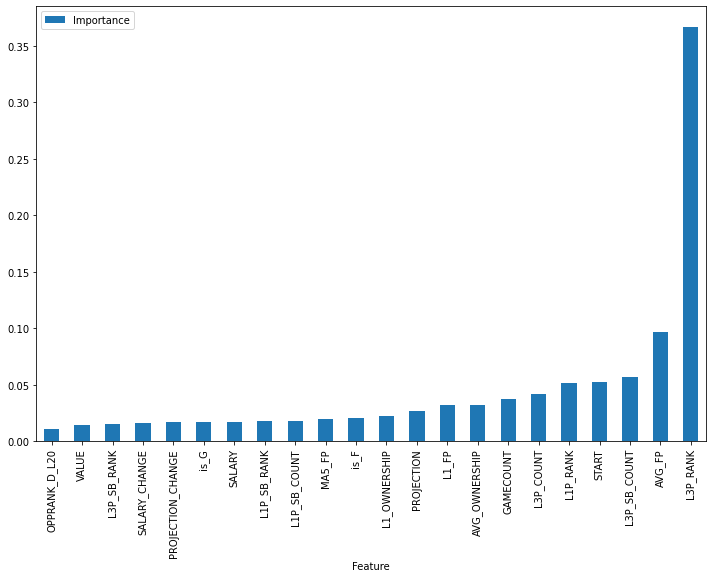

In [17]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
feature_importance_df.plot.bar(x='Feature', y='Importance', figsize=(12, 8))

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_avg = df.loc[X_test.index, 'AVG_OWNERSHIP'].fillna(df['OWNERSHIP'])

# Kpi
print("R2 (explained variance):")
print("Model:", round(r2_score(y_test, y_hat), 3))
print("Baseline:", round(r2_score(y_test, y_avg), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(mean_absolute_error(y_test, y_hat), 6))
print("Baseline:", round(mean_absolute_error(y_test, y_avg), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(mean_squared_error(y_test, y_hat)), 6))
print("Baseline:", round(np.sqrt(mean_squared_error(y_test, y_avg)), 6))

R2 (explained variance):
Model: 0.706
Baseline: 0.297

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.039416
Baseline: 0.068115

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.077547
Baseline: 0.120022


No handles with labels found to put in legend.
No handles with labels found to put in legend.


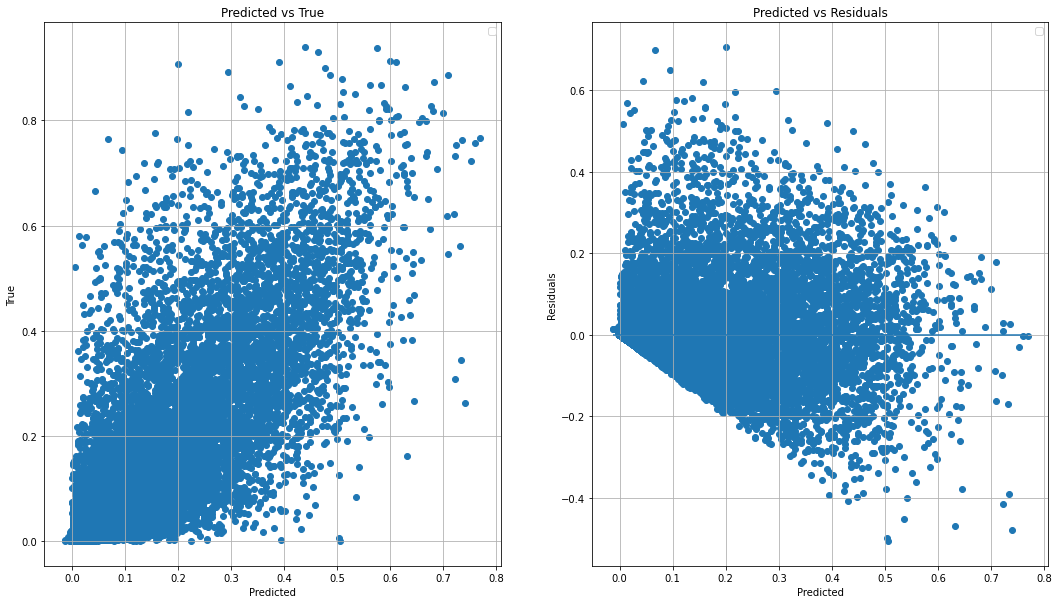

In [19]:
import matplotlib.pyplot as plt

residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
ax[0].scatter(y_hat, y_test)
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
ax[1].scatter(y_hat, residuals)
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

In [ ]:
df.loc[
    (df['PLAYER_NAME'] == 'Kenneth Faried') &
    (df['DATE'] == '2019-03-03')
].tail(10)